# How heterogeneously is the pandemic hitting the US right now?

After the last post (see [here](https://dangeles.github.io/jupyter/room_safety.html#How-safe-is-95%?)), multiple people commented on the fact that the pandemic has been characterized by its enormous heterogeneity throughout the US at the state and county and probably even neighborhood level. While I'm not particularly invested in getting data down to the county level, I thought it would be useful to see how safety profiles vary if I meet, say, $n = 3$ people every day since the pandemic started$*$ among the different states. 

Here's the punchline: As the pandemic has progressed, it has behaved differently among the various states. When this code was first written, on November 23 2020, I would have been very safe in Vermont if I met 3 *new* people every day until this date. However, in South Dakota, despite the lateness with which the pandemic hit, by November if I had met 3 people a day from inception to November 23 2020, there is an 80% chance I  bumped into at least 1 COVID positive person throughout the year. **Not good**.

Note: This post only talks about the behavior of ONE individual. If everyone behaved according to the probabilities seen here, then the situation would change rapidly and the virus would spread more. In essence, this blogpost is talking about the worst-case scenario where I **have** to meet individuals every day. My safety is a function of the degree of social distancing that others are doing in addition to other factors (how early the pandemic hit, conditions on the ground, etc...). This blogpost is *not* an endorsement for not socially distancing in some states, while socially distancing in others.

What this notebook shows is how different communities react differently to a virus. Some communities can *choose* to socially distance and thus maintain themselves safer for longer. Others do not have that privilege, while yet others may choose to forego it (for example, because they don't believe the virus is real). More than anything, I think this exercise shows the enormous impact that socioeconomics has on epidemiology.

Finally, please bear in mind that here I am using tests to estimate the probability of encountering a COVID(+) individual at any one time. As the pandemic changes, this may or may not be a good proxy. For example, we know that the first wave in NY, around March / April 2020, was likely 10x bigger than shown by tests. So these numbers should be taken with a grain of salt. The only thing I would trust at this time is the rough rank-ordering of states, assuming their positive test rates remain more-or-less constant, a likely terribly assumption!

$*$ here, the start of the pandemic is defined as normalized cases reaching $10^{-6}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

## Set up our safety function as in the previous post:

In [2]:
n = 2

def safety(p_covid, N=n):
    """Log of probability nobody has COVID in a room full of N people"""
    p = np.exp(N * np.log(1 - p_covid))

    if type(p) is not float:
        p[p >= 1] = 1
        return p
    else:
        if p <= 1:
            return p
        else:
            return 1

## Load the NYT data and run calculations

In [3]:
# load into a dataframe:
pop = pd.read_excel('../data/nst-est2019-01.xlsx', comment='#', header=1)

# fetch NYT data:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
df = pd.read_csv(url, usecols=[0, 1, 3, 4], parse_dates=['date'], squeeze=True)

pop.columns = np.append(np.array(['state']), pop.columns[1:].values)
pop.state = pop.state.str.strip('.')

# merge dfs:
df = df.merge(pop, left_on='state', right_on='state')
# calculate per population numbers:
df['normedPopCases'] = df.cases/ df[2019]

# drop days where normalized cases aren't high enough:
df = df[df.normedPopCases > 10 ** -6]

# generate smoothed prob of encountering a COVID + individual on any one day:
probs = df.groupby('state').normedPopCases.rolling(window=7, win_type='gaussian',
                                                   center=False).mean(std=2).diff(
                                                   ).rolling(10).agg(np.sum
                                                   ).reset_index().rename(
                                                   columns={'normedPopCases': 'pCOVID'})

# get our safety function:
probs['safety'] = probs.groupby('state').pCOVID.apply(safety)
# get cumulative safety to date:
probs['cumprob'] = probs.groupby('state').safety.cumprod()

# find best and worst states:
worst = probs[probs.cumprob == probs.groupby('state').apply(np.min).cumprob.min()].state.values[0]
best = probs[probs.cumprob == probs.groupby('state').apply(np.min).cumprob.max()].state.values[0]

# get cases assuming US is homogeneous:
cases = df.groupby('date').agg(np.sum).cases.rolling(window=7, win_type='gaussian',
                                                   center=False).mean(std=2).diff(
                                                   ).rolling(10).agg(np.sum) / pop[pop.state == 'United States'].Census.values[0]

total = safety(cases.values, n)

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  


# Plot daily safety levels:

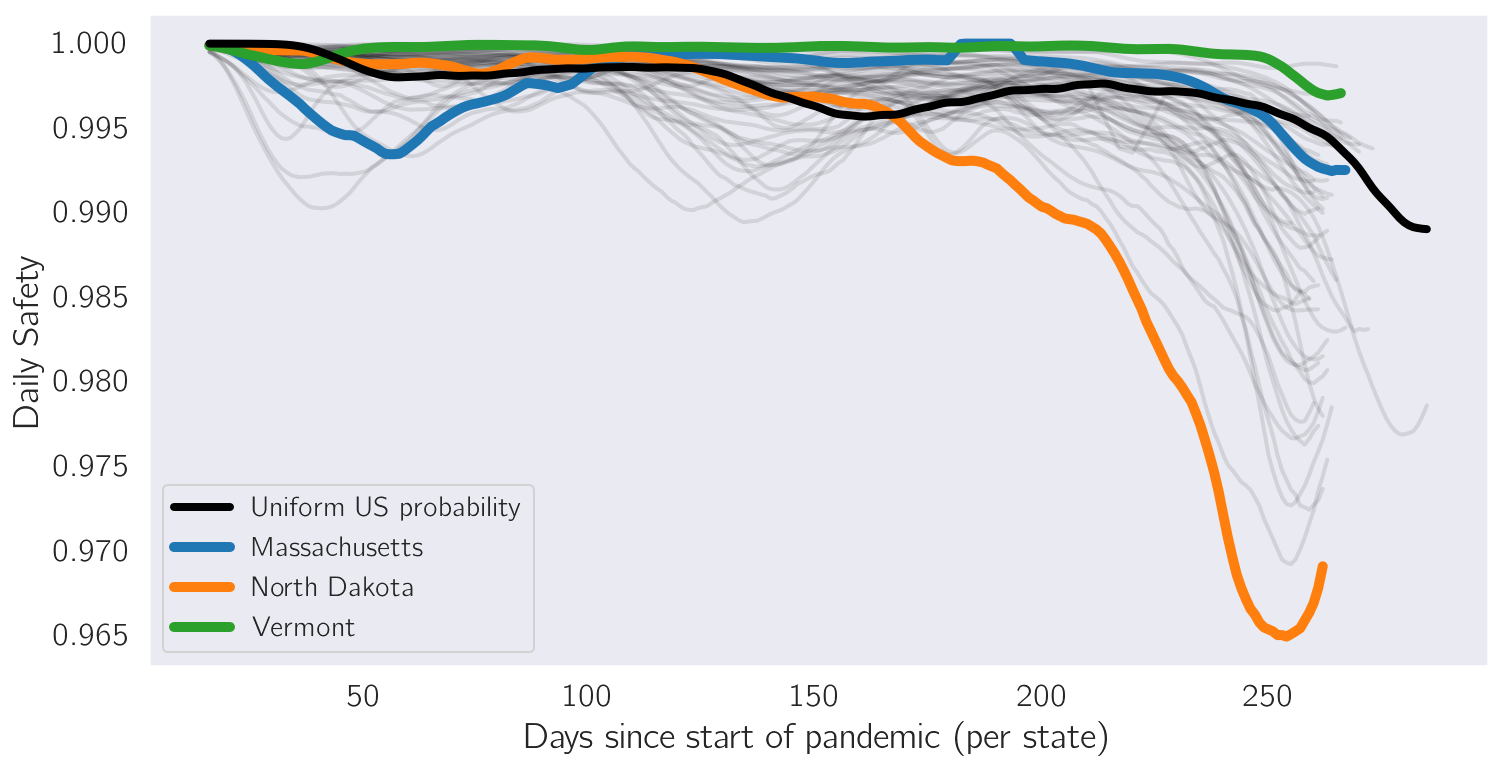

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(total, lw=4, color='black', label='Uniform US probability', zorder=np.inf)
for s, g in probs.groupby('state'):
    if s not in ['Massachusetts', worst, best]:
        plt.plot(g.safety.values, alpha=0.1, color='black', zorder=0)
    else:
        plt.plot(g.safety.values, alpha=1, label=s, lw=5)

plt.legend()
plt.xlabel('Days since start of pandemic (per state)')
_ = plt.ylabel('Daily Safety')

## Plot cumulative safety levels to date:

(Notice the log-y-scale)

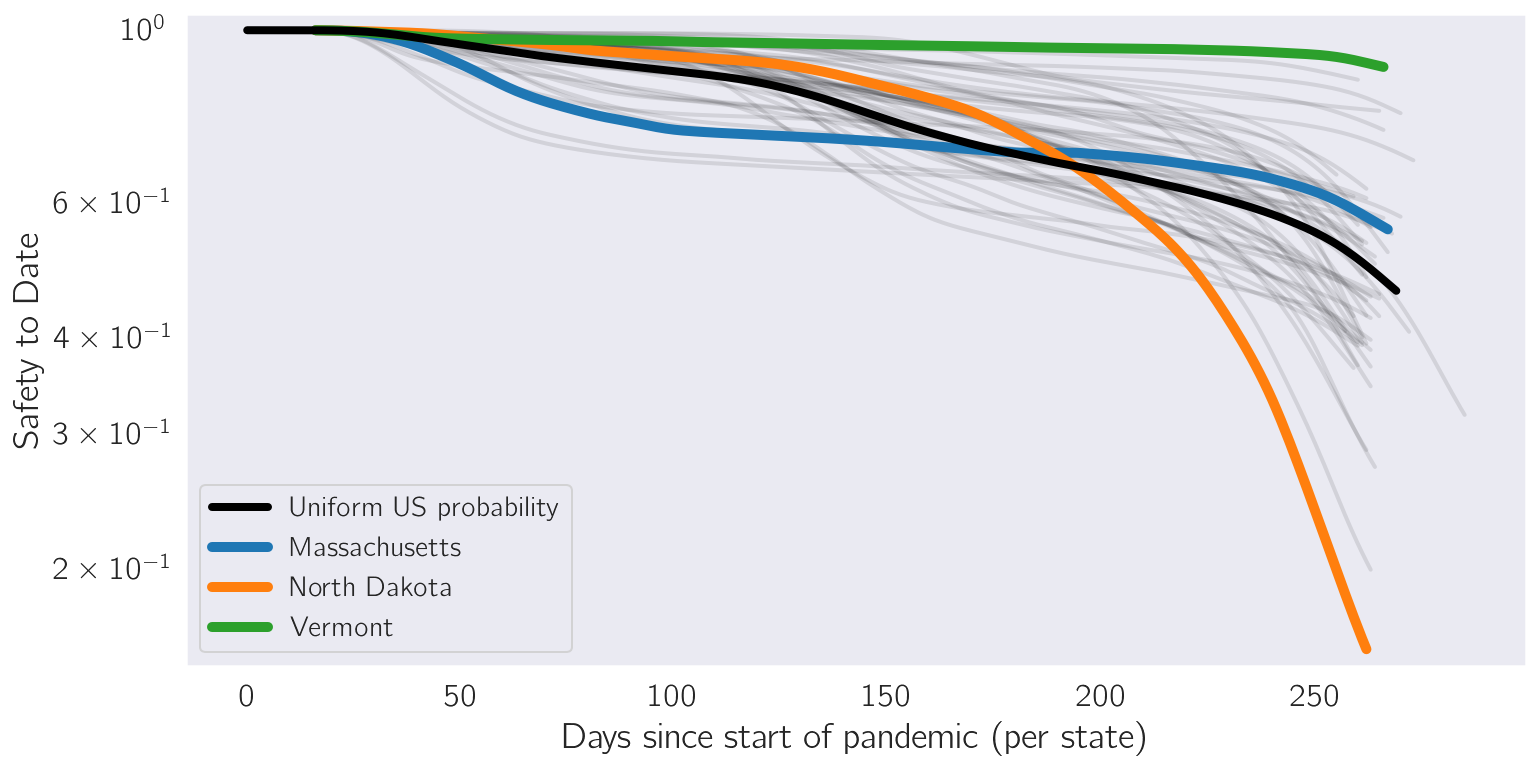

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(np.cumprod(total[~np.isnan(total)]), lw=4, color='black', label='Uniform US probability', zorder=np.inf)
for s, g in probs.groupby('state'):
    if s not in ['Massachusetts', worst, best]:
        plt.plot(g.cumprob.values, alpha=0.1, color='black', zorder=0)
    else:
        plt.plot(g.cumprob.values, alpha=1, label=s, lw=5)

plt.ylim(probs.cumprob.min() * .95, 1.05)
plt.yscale('log')
plt.legend()
plt.xlabel('Days since start of pandemic (per state)')
_ = plt.ylabel('Safety to Date')

## Plot cumulative safety to date levels per state:

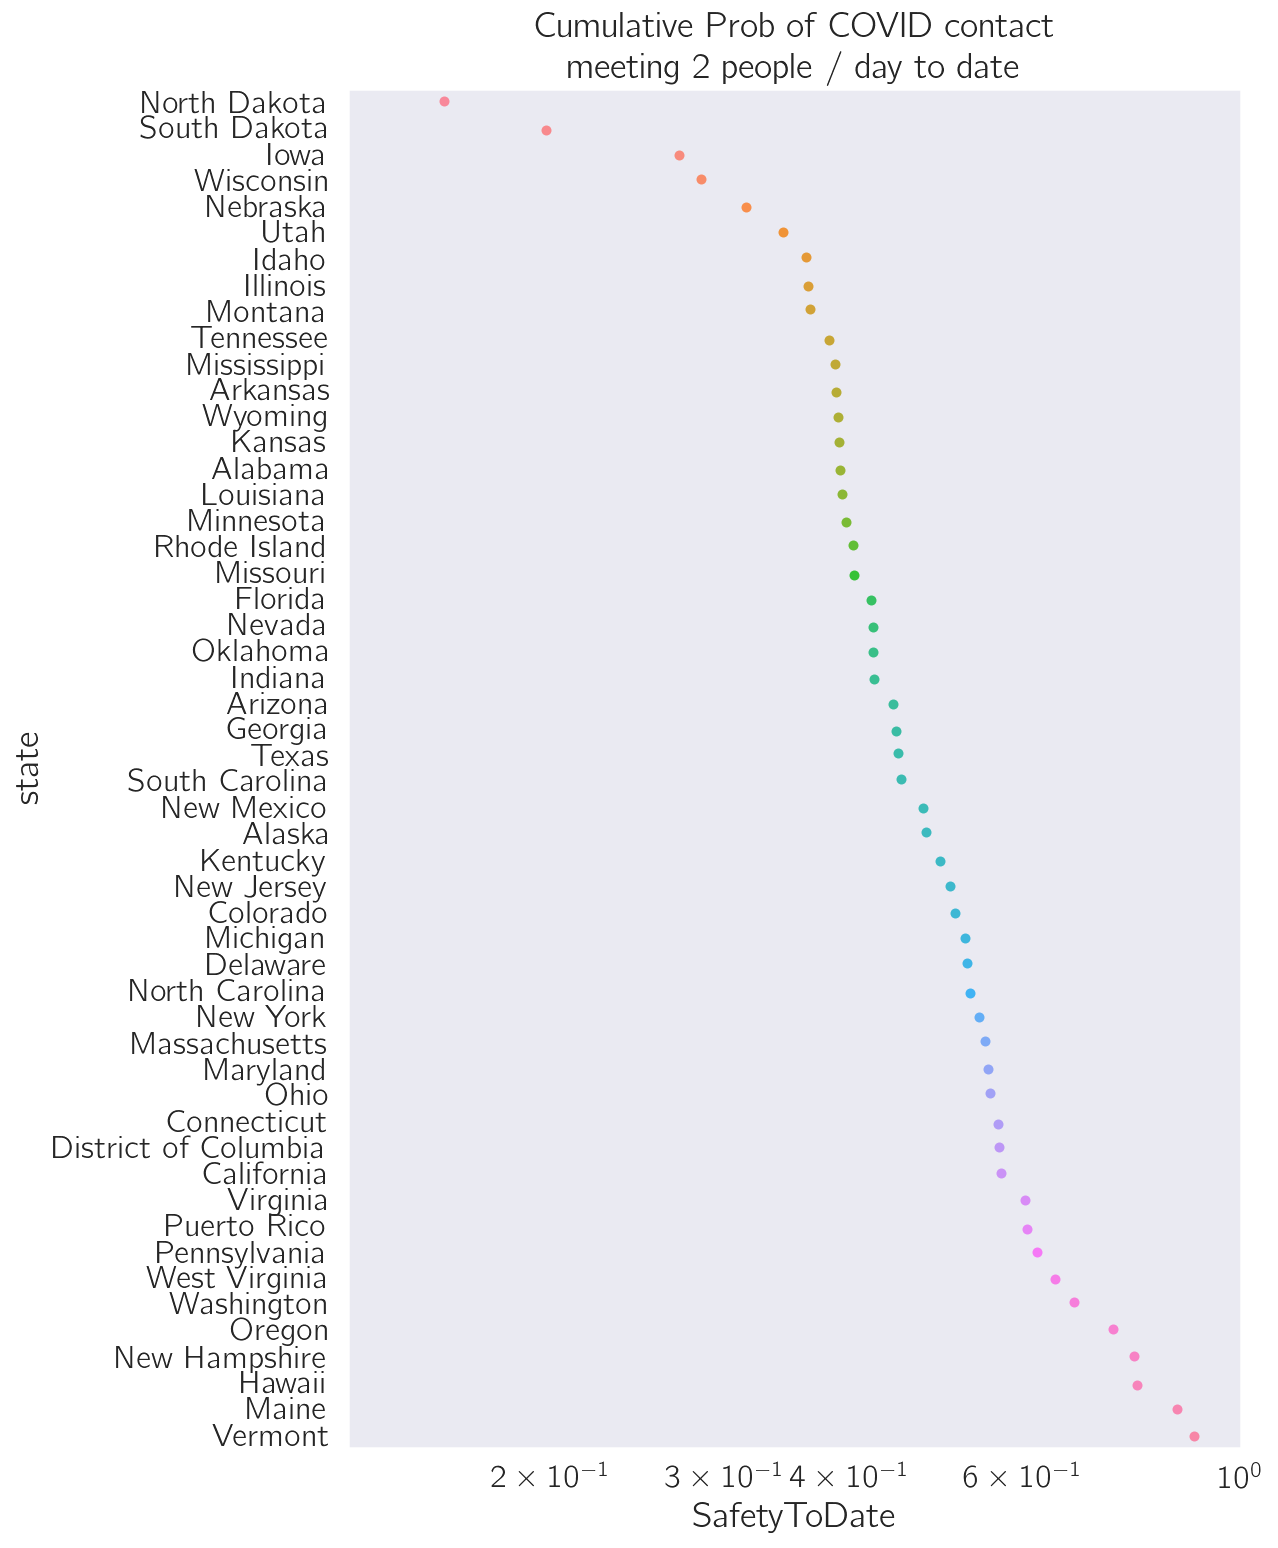

In [6]:
todate = probs.groupby('state').cumprob.apply(np.min).reset_index(
                         ).rename({'cumprob': 'SafetyToDate'}, axis=1).sort_values('SafetyToDate')
fig, ax = plt.subplots(figsize=(8, 12.5))
sns.stripplot(x='SafetyToDate', y='state', data=todate)
plt.xlim(todate.SafetyToDate.min() * .8, 1)
plt.xscale('log')
_ = plt.title('Cumulative Prob of COVID contact\nmeeting {0} people / day to date'.format(n))

Point of the story: Be aware of what communities you inhabit. Different communities, different safety profiles. Be proactively safe!